In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
#importing the data set
df = pd.read_csv('Mod1ProjData.csv')

In [3]:
#preview of the data set
df.head()

,Unnamed: 0,Unnamed: 0.1,movie,title,id_y,release_date,production_budget,date,studio,year,...,averagerating,numvotes,foreign_gross,profit,profitrate,foreign_share,actorage,actressage,fsdummy,regiondummy
0,0,0,Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,2.0,"May 20, 2011",410600000.0,2011-05-20,BV,2011.0,...,6.6,447624.0,8.046000e+08,6.350639e+08,154.667286,76.946332,59.0,37.0,1.0,1.0
1,1,1,Avengers: Age of Ultron,Avengers: Age of Ultron,4.0,"May 1, 2015",330600000.0,2015-05-01,BV,2015.0,...,7.3,665594.0,9.440081e+08,1.072414e+09,324.384139,67.284298,41.0,NaN,1.0,1.0
2,2,2,Avengers: Infinity War,Avengers: Infinity War,7.0,"Apr 27, 2018",300000000.0,2018-04-27,BV,2018.0,...,8.5,670926.0,1.369319e+09,1.748134e+09,582.711400,66.856885,44.0,NaN,1.0,1.0
3,3,3,Justice League,Justice League,9.0,"Nov 17, 2017",300000000.0,2017-11-17,WB,2017.0,...,6.5,329135.0,4.269209e+08,3.559452e+08,118.648403,65.084844,36.0,32.0,1.0,1.0
4,4,4,Spectre,Spectre,10.0,"Nov 6, 2015",300000000.0,2015-11-06,Sony,2015.0,...,6.8,352504.0,6.795467e+08,5.796209e+08,193.206974,77.254500,53.0,30.0,1.0,1.0


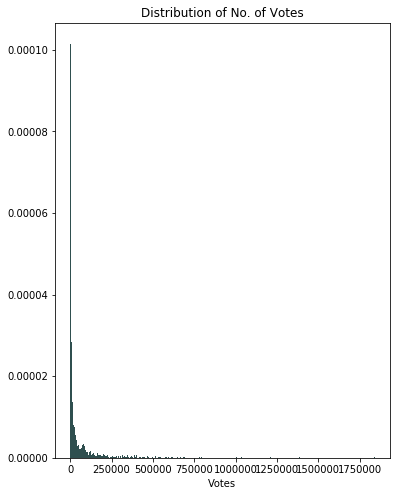

In [4]:
#Plotting to check the numvotes distribution
votes = df[(df.numvotes.notnull() == True)& (df.numvotes > 0)]

figure = plt.figure(figsize=(6, 8))
binwidth =0.1
axes = figure.add_subplot(1, 1, 1)
axes.hist(votes.numvotes, bins=1000, color="darkslategray", density = True)
axes.set_title("Distribution of No. of Votes")
axes.set_xlabel("Votes")

plt.show()
plt.close()

### Note:

From the chart above, it would be challenging to identify the proper distribution and values of the population that voted. Hence, transforming the feature to show a normal distribution might be feasible to identify the quantity in which a minimum threshold will be set to deem the movie "viewable".

In [5]:
#transforming numvotes
votes = votes.loc[votes['numvotes'] > 0]
votes['log_votes'] = votes['numvotes'].apply(np.log)
votes['log_votes'].describe()

count    2879.000000
mean        9.427632
std         2.259809
min         1.609438
25%         8.111027
50%         9.615139
75%        11.153087
max        14.425855
Name: log_votes, dtype: float64

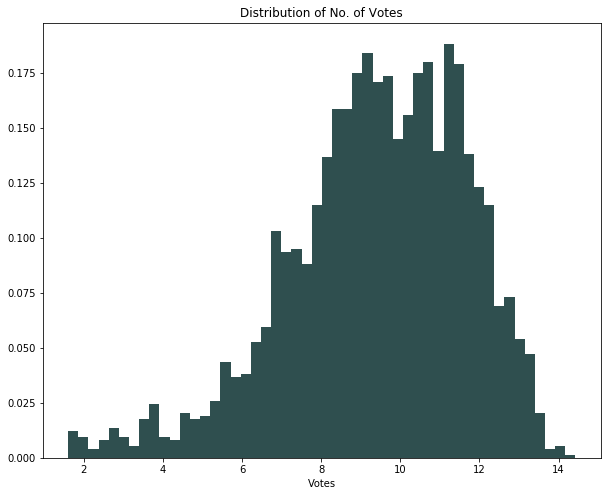

In [6]:
#checking the numvotes distribution
figure = plt.figure(figsize=(10, 8))
axes = figure.add_subplot(1, 1, 1)
axes.hist(votes.log_votes, bins=50, color="darkslategray", density = True)
axes.set_title("Distribution of No. of Votes")
axes.set_xlabel("Votes")

plt.show()
plt.close()

### Note:

The new chart now shows a similar to a normal distribution. Hence, we can easily see if there are a lot of outliers. From this transformation, will extract the 95% CI for the transformed number of votes (via numpy.log) and get the inverse to identify the threshold of number of votes.

In [7]:
#minimum number of votes to consider movie
stats.mstats.mquantiles( votes.log_votes, [0.05, 0.95])

array([ 5.3981627 , 12.66710166])

In [8]:
#Converting the 2.5% percentile of the sample
np.exp(3.25809654)

26.000000051441464

### Note:
From the results above, a viable movie to be considered viewable for audience should have at least 26 views.

# Gender Lead vs Genre
The intent of the following exploration is to determine at which genre and gender is most profitable from all the movie data gathered.

In [9]:
#creating series to identify the gender of the lead for the movie
df['gender_lead'] = 0

#fill actor & actress order value
df.actor_ordering = np.where(df.actor_ordering ==np.nan, df.actor_ordering.mean, df.actor_ordering)
df.actress_ordering = np.where(df.actress_ordering ==np.nan, df.actress_ordering.mean, df.actress_ordering)

From above, we now have a non-null values for the features that would be used to determine the genre and gender of the profitable movie.

Next step is to assign values if the lead for the entry/movie is a male of female which is dictated by the ordering, the lower the ordering is, the higher significany/heirarchy of the gender.

In [10]:
#creating a series for gender of lead actor/actress
df.gender_lead = np.where(df.actor_ordering < df.actress_ordering,'male', 'female')

#filling in missing world gross
df.worldwide_gross = np.where(df.worldwide_gross ==np.nan, df.worldwide_gross.mean(), df.worldwide_gross)

In [11]:
#list of genres
genres = ['Mystery', 'Drama',
       'Animation', 'Game-Show', 'News', 'Biography', 'Short', 'Action',
       'Family', 'Sport', 'Crime', 'War', 'Horror', 'Music', 'Reality-TV',
       'Fantasy', 'Documentary', 'Comedy', 'Western', 'Thriller', 'Talk-Show',
       'Musical', 'Romance', 'Sci-Fi', 'Adult', 'Adventure', 'History']

To segregate the different geographical gross of the movie per genre, dummy variables are needed to identify the specific gross/performance of the movie.

In [12]:
#Creating dummy series
for genre in genres:
    df[(genre +'_f_gross')] = None
    df[(genre +'_d_gross')] = None
    df[(genre +'_w_gross')] = None

In [13]:
#putting values for the dummy series
for genre in genres:
    df[(genre +'_f_gross')] = np.where(df[genre] == True, df.foreign_gross, 0)
    df[(genre +'_d_gross')] = np.where(df[genre] == True, df.domestic_gross, 0)
    df[(genre +'_w_gross')] = np.where(df[genre] == True, df.worldwide_gross, 0)

In [14]:
#list of all the series created per genre and geography
gross_types = ['Mystery_f_gross', 'Mystery_d_gross', 'Mystery_w_gross', 'Drama_f_gross', 'Drama_d_gross',
 'Drama_w_gross', 'Animation_f_gross', 'Animation_d_gross', 'Animation_w_gross', 'Game-Show_f_gross',
 'Game-Show_d_gross', 'Game-Show_w_gross', 'News_f_gross', 'News_d_gross', 'News_w_gross', 'Biography_f_gross',
 'Biography_d_gross', 'Biography_w_gross', 'Short_f_gross', 'Short_d_gross', 'Short_w_gross', 'Action_f_gross',
 'Action_d_gross', 'Action_w_gross', 'Family_f_gross', 'Family_d_gross', 'Family_w_gross', 'Sport_f_gross', 'Sport_d_gross',
 'Sport_w_gross', 'Crime_f_gross', 'Crime_d_gross', 'Crime_w_gross', 'War_f_gross', 'War_d_gross', 'War_w_gross',
 'Horror_f_gross', 'Horror_d_gross', 'Horror_w_gross', 'Music_f_gross', 'Music_d_gross', 'Music_w_gross', 'Reality-TV_f_gross',
 'Reality-TV_d_gross', 'Reality-TV_w_gross', 'Fantasy_f_gross', 'Fantasy_d_gross', 'Fantasy_w_gross', 'Documentary_f_gross',
 'Documentary_d_gross', 'Documentary_w_gross', 'Comedy_f_gross', 'Comedy_d_gross', 'Comedy_w_gross', 'Western_f_gross',
 'Western_d_gross', 'Western_w_gross', 'Thriller_f_gross', 'Thriller_d_gross', 'Thriller_w_gross', 'Talk-Show_f_gross', 'Talk-Show_d_gross',
 'Talk-Show_w_gross', 'Musical_f_gross', 'Musical_d_gross', 'Musical_w_gross', 'Romance_f_gross', 'Romance_d_gross',
 'Romance_w_gross', 'Sci-Fi_f_gross', 'Sci-Fi_d_gross', 'Sci-Fi_w_gross', 'Adult_f_gross', 'Adult_d_gross',
 'Adult_w_gross', 'Adventure_f_gross', 'Adventure_d_gross', 'Adventure_w_gross', 'History_f_gross', 'History_d_gross',
 'History_w_gross']

To identify the gender for the lead roles in each genre,it would require to create dataframes, one for male and one for female leads.

In [15]:
#Dataframe for female lead
female_gross = df[(df.gender_lead == 'female')&(df.numvotes > 26)][['Mystery_w_gross',
 'Drama_w_gross',
 'Animation_w_gross',
 'Game-Show_w_gross',
 'News_w_gross',
 'Biography_w_gross',
 'Short_w_gross',
 'Action_w_gross',
 'Family_w_gross',
 'Sport_w_gross',
 'Crime_w_gross',
 'War_w_gross',
 'Horror_w_gross',
 'Music_w_gross',
 'Reality-TV_w_gross',
 'Fantasy_w_gross',
 'Documentary_w_gross',
 'Comedy_w_gross',
 'Western_w_gross',
 'Thriller_w_gross',
 'Talk-Show_w_gross',
 'Musical_w_gross',
 'Romance_w_gross',
 'Sci-Fi_w_gross',
 'Adult_w_gross',
 'Adventure_w_gross',
 'History_w_gross']]

In [16]:
#Dataframe for male lead
male_gross = df[(df.gender_lead == 'male')&(df.numvotes > 26)][['Mystery_w_gross',
 'Drama_w_gross',
 'Animation_w_gross',
 'Game-Show_w_gross',
 'News_w_gross',
 'Biography_w_gross',
 'Short_w_gross',
 'Action_w_gross',
 'Family_w_gross',
 'Sport_w_gross',
 'Crime_w_gross',
 'War_w_gross',
 'Horror_w_gross',
 'Music_w_gross',
 'Reality-TV_w_gross',
 'Fantasy_w_gross',
 'Documentary_w_gross',
 'Comedy_w_gross',
 'Western_w_gross',
 'Thriller_w_gross',
 'Talk-Show_w_gross',
 'Musical_w_gross',
 'Romance_w_gross',
 'Sci-Fi_w_gross',
 'Adult_w_gross',
 'Adventure_w_gross',
 'History_w_gross']]

From the created dataframes, it will then be populated by its respective statistical mean for the intent of using any rows of the data_frames for the new data frame with a single dimension with the average value of gross per genre.

In [17]:
#computing the mean per genre per gender
for x in female_gross:
    female_gross[x]= female_gross[x].mean()
    male_gross[x]= male_gross[x].mean()

Now, we create an empy dataframe and insert any row of the male and female gross dataframe.

In [18]:
#generating an empty dataframe
genre_avg_gross_f=pd.DataFrame()
genre_avg_gross_m= pd.DataFrame()

In [19]:
genre_avg_gross_f = female_gross.iloc[0,:]
genre_avg_gross_m = male_gross.iloc[0,:]

In [20]:
type(genre_avg_gross_f)

pandas.core.series.Series

In [21]:
#Renaming Indices to use as X-labels
genre_avg_gross_f.index = genre_avg_gross_f.index.str.replace('_w_gross', '')
genre_avg_gross_m.index = genre_avg_gross_m.index.str.replace('_w_gross', '')

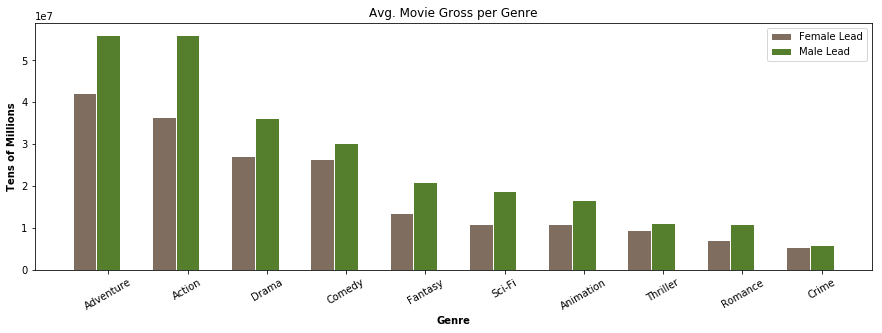

In [22]:
figure = plt.figure(figsize=(15, 10))
axes = figure.add_subplot(2, 1, 1)
# set width of bar
barWidth = 0.3
 
# set height of bar
bars1 = genre_avg_gross_f
bars2 = genre_avg_gross_m

bars1 = bars1.sort_values(ascending = False).head(10)
bars2 = bars2.sort_values(ascending = False).head(10)

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='Female Lead')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='Male Lead')

 
# Add xticks on the middle of the group bars
plt.xlabel('Genre', fontweight='bold')
plt.ylabel('Tens of Millions', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], list(bars1.index))
axes.set_xticklabels(axes.get_xticklabels(),rotation=30)


plt.savefig('Avg Movie Gross(Gender).jpg')
plt.title('Avg. Movie Gross per Genre')
# Create legend & Show graphic
plt.legend()
plt.show()


## Result:
It is very easy to identify the movie genre that had the largest gross with respect to genre and the gender the of lead.

# Geographical Movie Gross per Genre

From the previous result, we now would want to Identify the market that projected the gross results per genre. We want to see what type of movies or where the movies sell the most. 

In [23]:
#New data frame for genres
genre_gross = df[gross_types]

In [24]:
genre_gross.describe()

,Mystery_f_gross,Mystery_d_gross,Mystery_w_gross,Drama_f_gross,Drama_d_gross,Drama_w_gross,Animation_f_gross,Animation_d_gross,Animation_w_gross,Game-Show_f_gross,...,Sci-Fi_w_gross,Adult_f_gross,Adult_d_gross,Adult_w_gross,Adventure_f_gross,Adventure_d_gross,Adventure_w_gross,History_f_gross,History_d_gross,History_w_gross
count,2.874000e+03,2.929000e+03,2.874000e+03,2.291000e+03,2.921000e+03,2.291000e+03,2.890000e+03,2.929000e+03,2.890000e+03,2930.0,...,2.912000e+03,2930.0,2930.0,2930.0,2.863000e+03,2.928000e+03,2.863000e+03,2.873000e+03,2.929000e+03,2.873000e+03
mean,2.639995e+06,1.705617e+06,4.355528e+06,1.689732e+07,8.987379e+06,2.811819e+07,8.680974e+06,4.693001e+06,1.342511e+07,0.0,...,1.433352e+07,0.0,0.0,0.0,3.012491e+07,1.548254e+07,4.592702e+07,1.171900e+06,8.367652e+05,1.999729e+06
std,2.356815e+07,1.312340e+07,3.541291e+07,6.061239e+07,2.940145e+07,8.821333e+07,5.704288e+07,3.191596e+07,8.733890e+07,0.0,...,1.074018e+08,0.0,0.0,0.0,1.138906e+08,6.297274e+07,1.739306e+08,1.428431e+07,1.062672e+07,2.416466e+07
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,...,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,...,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.430000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,...,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,6.702305e+06,1.513793e+06,1.485377e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.0,...,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,6.643000e+08,2.961316e+08,9.604316e+08,9.605000e+08,5.040142e+08,1.341693e+09,8.242904e+08,6.085817e+08,1.242521e+09,0.0,...,2.048134e+09,0.0,0.0,0.0,1.369319e+09,9.366622e+08,2.053311e+09,4.977743e+08,3.564617e+08,8.542360e+08


In [25]:
#change all values into mean of the column
for x in genre_gross:
    genre_gross[x] = genre_gross[x].mean()

In [26]:
genre_gross.describe()

,Mystery_f_gross,Mystery_d_gross,Mystery_w_gross,Drama_f_gross,Drama_d_gross,Drama_w_gross,Animation_f_gross,Animation_d_gross,Animation_w_gross,Game-Show_f_gross,...,Sci-Fi_w_gross,Adult_f_gross,Adult_d_gross,Adult_w_gross,Adventure_f_gross,Adventure_d_gross,Adventure_w_gross,History_f_gross,History_d_gross,History_w_gross
count,2.930000e+03,2.930000e+03,2.930000e+03,2.930000e+03,2.930000e+03,2.930000e+03,2.930000e+03,2.930000e+03,2.930000e+03,2930.0,...,2.930000e+03,2930.0,2930.0,2930.0,2.930000e+03,2.930000e+03,2.930000e+03,2.930000e+03,2.930000e+03,2.930000e+03
mean,2.639995e+06,1.705617e+06,4.355528e+06,1.689732e+07,8.987379e+06,2.811819e+07,8.680974e+06,4.693001e+06,1.342511e+07,0.0,...,1.433352e+07,0.0,0.0,0.0,3.012491e+07,1.548254e+07,4.592702e+07,1.171900e+06,8.367652e+05,1.999729e+06
std,8.383334e-09,6.497084e-08,2.086519e-07,7.228297e-07,3.912222e-07,1.229556e-07,4.843704e-07,2.775815e-07,5.719297e-07,0.0,...,5.123148e-07,0.0,0.0,0.0,5.030000e-07,1.956111e-07,2.697571e-06,4.424537e-09,4.075232e-09,3.632778e-08
min,2.639995e+06,1.705617e+06,4.355528e+06,1.689732e+07,8.987379e+06,2.811819e+07,8.680974e+06,4.693001e+06,1.342511e+07,0.0,...,1.433352e+07,0.0,0.0,0.0,3.012491e+07,1.548254e+07,4.592702e+07,1.171900e+06,8.367652e+05,1.999729e+06
25%,2.639995e+06,1.705617e+06,4.355528e+06,1.689732e+07,8.987379e+06,2.811819e+07,8.680974e+06,4.693001e+06,1.342511e+07,0.0,...,1.433352e+07,0.0,0.0,0.0,3.012491e+07,1.548254e+07,4.592702e+07,1.171900e+06,8.367652e+05,1.999729e+06
50%,2.639995e+06,1.705617e+06,4.355528e+06,1.689732e+07,8.987379e+06,2.811819e+07,8.680974e+06,4.693001e+06,1.342511e+07,0.0,...,1.433352e+07,0.0,0.0,0.0,3.012491e+07,1.548254e+07,4.592702e+07,1.171900e+06,8.367652e+05,1.999729e+06
75%,2.639995e+06,1.705617e+06,4.355528e+06,1.689732e+07,8.987379e+06,2.811819e+07,8.680974e+06,4.693001e+06,1.342511e+07,0.0,...,1.433352e+07,0.0,0.0,0.0,3.012491e+07,1.548254e+07,4.592702e+07,1.171900e+06,8.367652e+05,1.999729e+06
max,2.639995e+06,1.705617e+06,4.355528e+06,1.689732e+07,8.987379e+06,2.811819e+07,8.680974e+06,4.693001e+06,1.342511e+07,0.0,...,1.433352e+07,0.0,0.0,0.0,3.012491e+07,1.548254e+07,4.592702e+07,1.171900e+06,8.367652e+05,1.999729e+06


The challenge now is to group the column values per genre (worldwide,foreig,domestic) to be able to compare and show the values. 

In [27]:
#Creating empty list to use for bar charts
###foreign gross
gbars1 = []

###Domestic Gross
gbars2 = []

###Wordwide Gross
gbars3 = []

#iterating through the 3 type of gross per genre
for i in range(0,81,3): 

    gbars1.append(genre_gross.iloc[0,i])
    gbars2.append(genre_gross.iloc[0,i+1])
    gbars3.append(genre_gross.iloc[0,i+2])

#sorting the gross data
gbars1.sort(reverse = True)
gbars2.sort(reverse = True)
gbars3.sort(reverse = True)


#keeping the top 10 values
gbars1=gbars1[0:10]
gbars2=gbars2[0:10]
gbars3=gbars3[0:10]

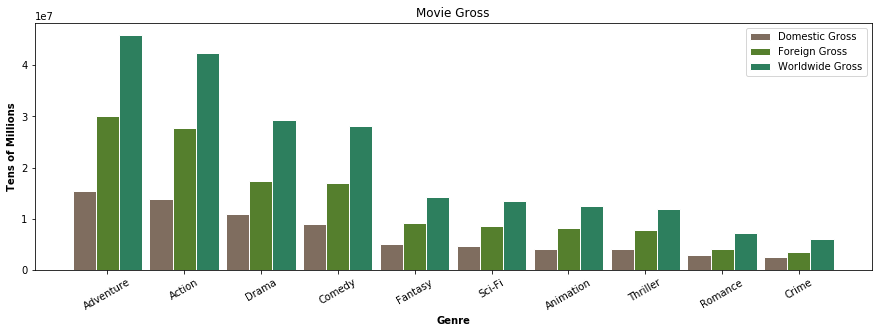

In [28]:
#Creating grouped barchart
figure = plt.figure(figsize=(15, 10))
axes = figure.add_subplot(2, 1, 1)

# set width of bar
barWidth = 0.3

 
# Set position of bar on X axis
r1 = np.arange(len(gbars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
    # Make the plot
plt.bar(r1, gbars2, color='#7f6d5f', width=barWidth, edgecolor='white', label='Domestic Gross')
plt.bar(r2, gbars1, color='#557f2d', width=barWidth, edgecolor='white', label='Foreign Gross')
plt.bar(r3, gbars3, color='#2d7f5e', width=barWidth, edgecolor='white', label='Worldwide Gross')
    
 
# Add xticks o the middle of the group bars
plt.xlabel('Genre', fontweight='bold')
plt.ylabel('Tens of Millions', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(gbars1))], list(bars1.index))
axes.set_xticklabels(axes.get_xticklabels(),rotation=30)

plt.title('Movie Gross')
# Create legend & Show graphic
plt.legend()
plt.savefig('Movie Gross.jpg')
plt.show()



## Result
From the chart above, we identify the major gross from the foreign market compared to the domestic sales considtently from the top 10 gross earning genres.

# Movie Length vs  Profit vs Budget

With the knowledge of identifying the target market and the genre, we can explore the content of the movie itself. One feature we can consider is the length of the movie, the budget and the respective profit.

In [29]:
#create a new dataframe 
df_run_gross = df[(df['numvotes']>25)]
df_run_gross = df_run_gross[['worldwide_gross','runtime_minutes','production_budget','profit']]
df_run_gross.worldwide_gross = np.where(df_run_gross.worldwide_gross.isna() ==True, df_run_gross.worldwide_gross.mean(),df_run_gross.worldwide_gross)
df_run_gross.worldwide_gross = np.where(df_run_gross.worldwide_gross <= 0, df_run_gross.worldwide_gross.mean(),df_run_gross.worldwide_gross)
df_run_gross.runtime_minutes = np.where(df_run_gross.runtime_minutes.isna() ==True, df_run_gross.runtime_minutes.mean(),df_run_gross.runtime_minutes)
df_run_gross.head()

,worldwide_gross,runtime_minutes,production_budget,profit
0,1.045664e+09,136.0,410600000.0,6.350639e+08
1,1.403014e+09,141.0,330600000.0,1.072414e+09
2,2.048134e+09,149.0,300000000.0,1.748134e+09
3,6.559452e+08,120.0,300000000.0,3.559452e+08
4,8.796209e+08,148.0,300000000.0,5.796209e+08


In [30]:
#create a data frame with  production budget data
df_with_budget = df_run_gross[(df.production_budget.notnull())]

To emphasize on classifification on budget size and movie length, the percentiles of the data on production budget and run time will be acquired, 25th percentile as threshold for lower end, 75th for the higher end and in the middle would be the medium range of these values. 

In [31]:
#Getting percentiles for runtime
stats.mstats.mquantiles( df_with_budget.runtime_minutes, [0.25, 0.75])

array([ 96., 119.])

The next step would be creating a series in which the runtime will be classified accrodingly.

In [32]:
df_with_budget['Movie_Length'] = None

In [33]:
#classifying with Short, Average, and long Runtime
df_with_budget['Movie_Length'] = np.where(df_with_budget.runtime_minutes < 95, 'Short',df_with_budget.Movie_Length)
df_with_budget['Movie_Length'] = np.where((df_with_budget.runtime_minutes > 95)&(df_with_budget.runtime_minutes < 118),"Average",df_with_budget.Movie_Length)
df_with_budget['Movie_Length'] = np.where(df_with_budget.runtime_minutes > 118, 'Long',df_with_budget.Movie_Length)
df_with_budget.Movie_Length.value_counts()

Average    630
Long       329
Short      280
Name: Movie_Length, dtype: int64

In [34]:
#Acquiring quantiles for runtime
stats.mstats.mquantiles( df_with_budget.production_budget, [0.25,0.75])

array([12000000.        , 63599999.99999991])

Similar to the runtime, we will then classify the movie budget accordingly.

In [35]:
df_with_budget['Budget_Type'] = None

In [36]:
#classifying with Small, Medium, and Large budget
df_with_budget['Budget_Type'] = np.where(df_with_budget.production_budget < 10000000, 'Small',df_with_budget.Budget_Type)
df_with_budget['Budget_Type'] = np.where((df_with_budget.production_budget > 10000000)&(df_with_budget.production_budget < 60000000),"Medium",df_with_budget.Budget_Type)
df_with_budget['Budget_Type'] = np.where(df_with_budget.production_budget > 60000000, 'Large',df_with_budget.Budget_Type)
df_with_budget.Budget_Type.value_counts()

Medium    630
Large     330
Small     254
Name: Budget_Type, dtype: int64

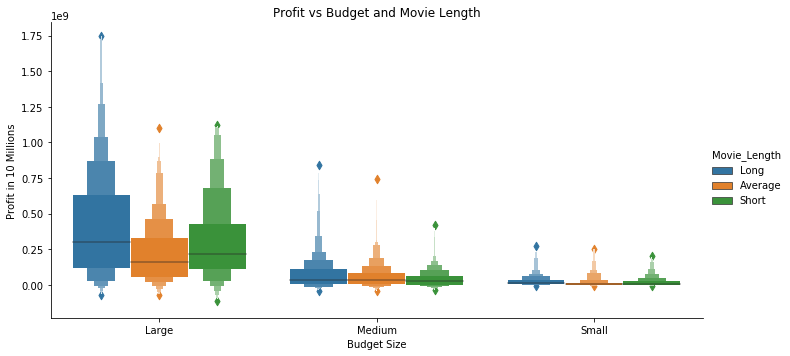

In [37]:
sns.catplot(hue= 'Movie_Length',x="Budget_Type", y="profit", kind="boxen", data=df_with_budget,height=5, aspect=2)
plt.xlabel('Budget Size')
plt.ylabel('Profit in 10 Millions')
plt.title('Profit vs Budget and Movie Length')
plt.savefig('Profit_vs_Budget_Length.jpg')
plt.show()

# Actor/Actress Age for Lead Role

In [38]:
#Creating data frame to use for classifying age of lead actor/actresses
df_lead_age = df[['actor_ordering','actor_age','actress_ordering','actress_age','year',"gender_lead"]]

In [39]:
df_lead_age.isna().sum()

actor_ordering      243
actor_age           445
actress_ordering    500
actress_age         750
year                  0
gender_lead           0
dtype: int64

In [40]:
#Filling in mean values for nulls
df_lead_age.actor_ordering = np.where(df_lead_age.actor_ordering.isna()==True, df_lead_age.actor_ordering.mean(),df_lead_age.actor_ordering)
df_lead_age.actress_ordering = np.where(df_lead_age.actress_ordering.isna()==True, df_lead_age.actress_ordering.mean(),df_lead_age.actress_ordering )
df_lead_age.actor_age = np.where(df_lead_age.actor_age.isna()==True, df_lead_age.actor_age.mean(),df_lead_age.actor_age)
df_lead_age.actress_age = np.where(df_lead_age.actress_age.isna()==True, df_lead_age.actress_age.mean(),df_lead_age.actress_age )

In [41]:
df_lead_age.head()

,actor_ordering,actor_age,actress_ordering,actress_age,year,gender_lead
0,2.66667,1952.0,2,1974.000000,2011.0,female
1,2.5,1974.0,2.61685,1976.746735,2015.0,female
2,2.5,1974.0,2.61685,1976.746735,2018.0,female
3,2.66667,1981.0,2,1985.000000,2017.0,female
4,2.33333,1962.0,3,1985.000000,2015.0,male


The next step is to calculate the age of the lead actor/actress during the release of the movie.

In [42]:
df_lead_age['actor_age_of_role'] = df_lead_age.year - df_lead_age.actor_age
df_lead_age['actress_age_of_role'] = df_lead_age.year - df_lead_age.actress_age
df_lead_age.head()

,actor_ordering,actor_age,actress_ordering,actress_age,year,gender_lead,actor_age_of_role,actress_age_of_role
0,2.66667,1952.0,2,1974.000000,2011.0,female,59.0,37.000000
1,2.5,1974.0,2.61685,1976.746735,2015.0,female,41.0,38.253265
2,2.5,1974.0,2.61685,1976.746735,2018.0,female,44.0,41.253265
3,2.66667,1981.0,2,1985.000000,2017.0,female,36.0,32.000000
4,2.33333,1962.0,3,1985.000000,2015.0,male,53.0,30.000000


Lastly, with all the data, classify via gender which has the lead role and attach it to a series for consolidated ages of the lead actor/actresses.

In [43]:
df_lead_age['lead_age'] = 0
df_lead_age['lead_age'] = np.where(df_lead_age.gender_lead == 'female', df_lead_age.actress_age_of_role, df_lead_age.actor_age_of_role)
df_lead_age.head()


,actor_ordering,actor_age,actress_ordering,actress_age,year,gender_lead,actor_age_of_role,actress_age_of_role,lead_age
0,2.66667,1952.0,2,1974.000000,2011.0,female,59.0,37.000000,37.000000
1,2.5,1974.0,2.61685,1976.746735,2015.0,female,41.0,38.253265,38.253265
2,2.5,1974.0,2.61685,1976.746735,2018.0,female,44.0,41.253265,41.253265
3,2.66667,1981.0,2,1985.000000,2017.0,female,36.0,32.000000,32.000000
4,2.33333,1962.0,3,1985.000000,2015.0,male,53.0,30.000000,53.000000


In [44]:
df_lead_age.isna().sum()

actor_ordering         0
actor_age              0
actress_ordering       0
actress_age            0
year                   0
gender_lead            0
actor_age_of_role      0
actress_age_of_role    0
lead_age               0
dtype: int64

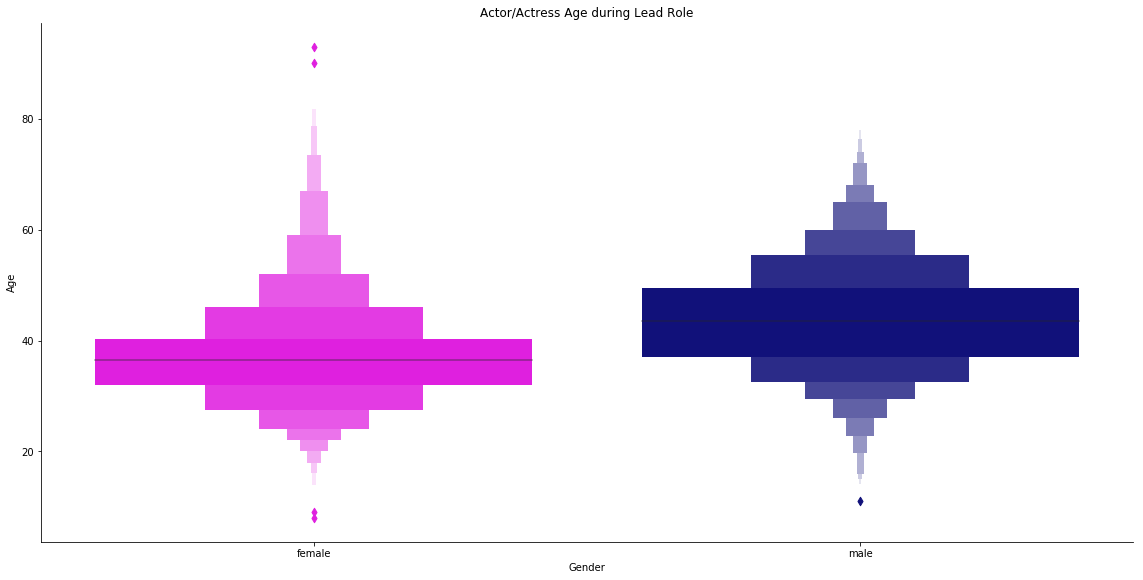

In [45]:
sns.catplot(x='gender_lead', y= 'lead_age', kind ='boxen', data = df_lead_age, height=8, aspect = 2,palette={"male": "darkblue", "female": "fuchsia"},)
plt.xlabel('Gender')
plt.ylabel('Age')
plt.title('Actor/Actress Age during Lead Role')
plt.savefig('Actor_Actress_Age.jpg')
plt.show()

Finally, we can see the distribution of the age for both male and female lead.